In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [2]:
df = pd.read_csv("premierleaguepassing.csv")
columns = ['Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1',
       'Cmp.2', 'Att.2', 'Cmp.3', 'Att.3', 'Ast', 'xAG',
       'xA', 'A-xAG', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']

# Set all columns to per 90 minutes
for col in columns:
    df[col] = df[col]/df["90s"] 
df = df.dropna()
df
df.columns

Index(['Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s',
       'Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1',
       'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'xAG',
       'xA', 'A-xAG', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP', 'Matches'],
      dtype='object')

In [3]:
df.sort_values("Att", ascending = False)

,Unnamed: 0,Player,Nation,Pos,Squad,Age,Born,90s,Cmp,Att,...,Ast,xAG,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP,Matches
345,345,Benjamin Mendy,fr FRA,DF,Manchester City,27.0,1994.0,0.9,88.888889,104.444444,...,0.000000,0.111111,0.111111,-0.111111,2.222222,10.000000,1.111111,1.111111,10.000000,Matches
190,190,Morgan Gibbs-White,eng ENG,"DF,FW",Wolves,21.0,2000.0,0.1,70.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,20.000000,Matches
69,69,João Cancelo,pt POR,DF,Manchester City,27.0,1994.0,35.9,78.245125,93.732591,...,0.194986,0.150418,0.183844,0.044568,1.086351,8.579387,2.674095,0.334262,9.944290,Matches
286,286,Aymeric Laporte,es ESP,DF,Manchester City,27.0,1994.0,31.4,88.598726,93.630573,...,0.000000,0.019108,0.041401,-0.019108,0.286624,9.840764,0.286624,0.063694,8.630573,Matches
563,563,Oleksandr Zinchenko,ua UKR,DF,Manchester City,24.0,1996.0,11.6,82.155172,92.500000,...,0.344828,0.232759,0.215517,0.112069,1.379310,8.965517,1.896552,0.431034,9.741379,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,405,Teemu Pukki,fi FIN,FW,Norwich City,31.0,1990.0,36.1,11.052632,14.958449,...,0.083102,0.105263,0.080332,-0.022161,0.747922,0.581717,0.166205,0.027701,0.941828,Matches
532,532,Matěj Vydra,cz CZE,FW,Burnley,29.0,1992.0,7.5,10.000000,14.266667,...,0.400000,0.093333,0.080000,0.306667,0.800000,0.133333,0.266667,0.000000,0.933333,Matches
528,528,Jamie Vardy,eng ENG,FW,Leicester City,34.0,1987.0,20.1,9.154229,13.184080,...,0.099502,0.069652,0.049751,0.029851,0.895522,0.447761,0.746269,0.099502,1.393035,Matches
94,94,Aaron Connolly,ie IRL,"FW,MF",Brighton,21.0,2000.0,1.7,8.235294,11.176471,...,0.000000,0.058824,0.058824,-0.058824,0.588235,0.000000,0.000000,0.000000,0.588235,Matches


Team (mean passes, max passes (per person)): Norwich City 37 60.33980582524271
Standard Deviation: 20.502651675593732
Team (mean passes, max passes (per person)): Southampton 36 59.85994397759103
Standard Deviation: 23.15635650597014
Team (mean passes, max passes (per person)): Wolves 46 100.0
Standard Deviation: 23.66796613579741
Team (mean passes, max passes (per person)): Brentford 37 61.44230769230769
Standard Deviation: 21.854134778142615
Team (mean passes, max passes (per person)): Manchester City 65 104.44444444444444
Standard Deviation: 24.368218172332554
Team (mean passes, max passes (per person)): Leicester City 48 75.42857142857143
Standard Deviation: 22.232667732915846
Team (mean passes, max passes (per person)): Liverpool 58 88.70588235294117
Standard Deviation: 22.187891718732807
Team (mean passes, max passes (per person)): Everton 34 54.0
Standard Deviation: 16.01364064491797
Team (mean passes, max passes (per person)): Tottenham 49 72.3943661971831
Standard Deviation: 1

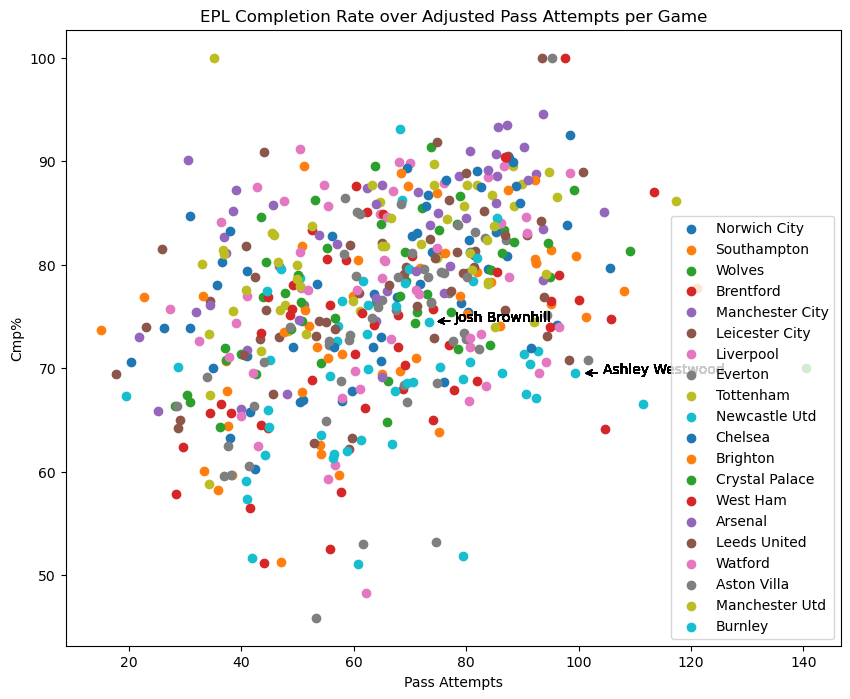

In [4]:
unique_team = df.Squad.unique()

fig, ax = plt.subplots(figsize=(10, 8))
keyPlayers = ["Ashley Westwood", "Josh Brownhill"]
passData = []
teams = []
means = []
maxes = []

for squad in unique_team:

    squad_data = df[df['Squad'] == squad]
    #print("Team:", squad)
    if not pd.isna(squad):
        print("Team (mean passes, max passes (per person)):",squad, int(squad_data.Att.mean()), squad_data.Att.max())

        x = squad_data.Att * (65.22 / squad_data.Att.mean()) #65.22 = Average passing attempts by Man City, the most of any team
        y = squad_data["Cmp%"]
        print("Standard Deviation:",x.std())
        ax.scatter(x, y, marker='o', label=squad)
        passData.append([squad, squad_data.Att.mean(), squad_data.Att.max(), squad_data.Att.std()])
        teams.append(squad)
        means.append(squad_data.Att.mean())
        maxes.append(squad_data.Att.max())
        keyPlayers = ["Ashley Westwood", "Josh Brownhill"]
        annotations = []
        for j, row in df.iterrows():
            if (row["Player"] in keyPlayers):
                ax.annotate(row['Player'], (row.Att * (65.22/32), row["Cmp%"]), xytext=(15, 0), textcoords='offset points', arrowprops=dict(arrowstyle='->'))


ax.set_xlabel('Pass Attempts')
ax.set_ylabel('Cmp%')
ax.set_title('EPL Completion Rate over Adjusted Pass Attempts per Game')


ax.legend()


plt.show()